MIDA Gondara and Wang(2018) in Python (using PyTorch)
https://arxiv.org/abs/1705.02737
https://gist.github.com/lgondara/18387c5f4d745673e9ca8e23f3d7ebd3 

# 1. Loading Dataset

## 1.1. Load a dataset and introduce missingness

Dataset used: Servo Dataset https://archive.ics.uci.edu/ml/datasets/Servo

### 1.1.1. Load the dataset and store it as dataframe(Numeric+Categorical)

In [1]:
import pandas as pd
import utils

In [8]:
#Test
filename = "data/servo/servo.data"
df = utils.get_dataframe_from_csv(filename, header_row = None, sep=',')

INFO:root:Input filename has to be space separated data


In [6]:
# #Test
# filename = "data/shuttle/shuttle_trn_debug"
# train_df = utils.get_dataframe_from_csv(filename).iloc[:,:-1]  #remove label

In [9]:
df.head()

,0,1,2,3,4
0,E,E,5,4,0.281251
1,B,D,6,5,0.506252
2,D,D,4,3,0.356251
3,B,A,3,2,5.500033
4,D,B,6,5,0.356251


In [11]:
df.dtypes

0     object
1     object
2      int64
3      int64
4    float64
dtype: object

### 1.1.2. Inducing missingness

After dataset loading, start with inducing missingness. 

To start off, introduce simple random missing patterns (Missing Completely At Random), i.e. sample half of the variables and set observations in those variables to missing if an appended random uniform vector has value less than a certain threshhold. WIth threshold of 0.2, the procedure should introduce about 20% missingness.

In [12]:
#test
df1 = df.copy()
df2 = utils.induce_missingness(df1,logger_level=20)

INFO:root: Returning new dataframe with missingness(MCAR) induced
INFO:root: Percentage of NaNs in returned dataframe : 7.19


In [13]:
df1.head()

,0,1,2,3,4
0,E,E,5,4,0.281251
1,B,D,6,5,0.506252
2,D,D,4,3,0.356251
3,B,A,3,2,5.500033
4,D,B,6,5,0.356251


In [14]:
df2.head()

,0,1,2,3,4
0,E,E,5,4,0.281251
1,B,NaN,6,5,NaN
2,D,D,4,3,0.356251
3,B,A,3,2,5.500033
4,D,B,6,5,0.356251


In [54]:
len(df), len(df1), len(df2)

(167, 167, 167)

### 1.1.3. Create Train-Test split

Create 70% training data and 30%  test data which includes missingness and a test data without missingness so we can calculate performance. 

In [15]:
#Test
train_df, test_df, full_test_df = utils.create_train_test_split(dataframe=df1, test_perc=0.3, logger_level=20)
print(train_df.head())
print(test_df.head())
print(full_test_df.head())

INFO:root: Returning new dataframe with missingness(MCAR) induced
INFO:root: Percentage of NaNs in returned dataframe : 7.19
INFO:root: Returning train_df, test_df, full_test_df after splitting dataframe in 0.7/0.3 split 
INFO:root: Note: full_test_df is the same as test_df but without NaNs


     0    1  2  3         4
3    B    A  3  2  5.500033
31   B    C  3  1  3.899964
97   C  NaN  4  1       NaN
102  B    D  3  1  3.899964
92   A  NaN  4  3       NaN
     0    1  2  3         4
144  A    C  3  1  3.899964
33   C  NaN  6  2       NaN
41   C  NaN  4  3       NaN
39   C    D  4  1  0.206250
4    D    B  6  5  0.356251
     0  1  2  3         4
144  A  C  3  1  3.899964
33   C  A  6  2  0.543753
41   C  B  4  3  0.881255
39   C  D  4  1  0.206250
4    D  B  6  5  0.356251


# 2. Modelling

Proceed to modelling.

In R:
Start with initializing 'h2o' package and then reading the training and test datasets as the 'h2o's supported format.
Then run imputation model multiple times as each new start would initialize the weights with different values.<br>
Info at: <br>
[h2o](https://cran.r-project.org/web/packages/h2o/h2o.pdf) package offers an easy to use function for implementing autoencoders. 
More information is available at this [link](http://docs.h2o.ai/h2o/latest-stable/h2o-docs/booklets/DeepLearningBooklet.pdf).

In Python: Using PyTorch to create the DAE, and train using the Adam optimizer from PyTorch

In [16]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.functional as F

In [17]:
#Settings for device, randomization seed, default tensor type, kwargs for memory #DevSeedTensKwargs
RANDOM_SEED = 18
np.random.seed(RANDOM_SEED)

if torch.cuda.is_available():
    device = 'cuda'
    torch.cuda.manual_seed(RANDOM_SEED)
    torch.set_default_tensor_type(torch.cuda.FloatTensor)
    kwargs = {'num_workers':4, 'pin_memory' :True}
else:
    device = 'cpu'
    torch.manual_seed(RANDOM_SEED)
    torch.set_default_tensor_type(torch.FloatTensor)
    kwards = {}

In [52]:
trainset = dataset_module_categorical.DataSetForImputation(train_df, normalize=True)  #normalize True for [0,1] normalization for dataframe

In [53]:
len(trainset)

116

In [55]:
import Modelling
net = Modelling.DenoisingAutoEncoder(len(trainset.variables()))

In [56]:
net

DenoisingAutoEncoder(
  (drop_layer): Dropout(p=0.5)
  (linear_layer_list): ModuleList(
    (0): Linear(in_features=5, out_features=12, bias=True)
    (1): Linear(in_features=12, out_features=19, bias=True)
    (2): Linear(in_features=19, out_features=26, bias=True)
    (3): Linear(in_features=26, out_features=19, bias=True)
    (4): Linear(in_features=19, out_features=12, bias=True)
    (5): Linear(in_features=12, out_features=5, bias=True)
  )
)

# 3. Training

In [16]:
import torch.utils.data as td
from torch.optim import Adam

LR = 1e-3
DATAPOINTS = len(trainset) 
BATCH_SIZE = 512 
BATCHES = DATAPOINTS/BATCH_SIZE
VARIABLES  = len(trainset.variables()) #9


import Modelling
net = Modelling.DenoisingAutoEncoder(len(trainset.variables()), theta = 7, input_dropout=0.5)

criterion = nn.MSELoss()
net = net.to(device) 

trainset = dataset_module_categorical.DataSetForImputation(train_df, normalize=True)
testset = dataset_module_categorical.DataSetForImputation(test_df, normalize=True)

train_loader = td.DataLoader(trainset, batch_size= BATCH_SIZE, shuffle= True, **kwargs)
val_loader  = td.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=True, **kwargs)

optimizer = Adam(net.parameters(), lr = LR)

LOG_INTERVAL = 10
SAVE_INTERVAL = 50
torch.set_printoptions(sci_mode=False)

In [18]:
'''
TO DO:
:- Nesterov Momentum + Adam- Pytorch? Decay factor?
'''
import os
from tqdm import tqdm_notebook as tqdm
def train_model(start_steps = 0, end_steps = 5, net=None, model_name = "DAE_Arch_N_7_ImputeOnlyNaNs_WithDropout", train_loader = train_loader, val_loader = val_loader, logger_level = 20):
    import logging
    logger = logging.getLogger()
    logger.setLevel(logger_level)

    NaN_flag = False
    
    for epoch in tqdm(range(start_steps, end_steps)):
        count = epoch-start_steps+1
        net.train()
        #Epoch begins
        epoch_loss = 0.0
        for x, d in tqdm(train_loader):
            # Normalize between [0,1] for better convergence 
            original_x = x
            x[torch.isnan(x)]=0   #If an entire column is zero, division by 0, replace NaNs with zero
            d[torch.isnan(d)]=0 

            optimizer.zero_grad()
            x = x.to(device)
            with torch.no_grad():
                d = d.to(device)
            y = net(x)
            loss = torch.sqrt(criterion(y, d))   #RMSE Loss   
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            
            #Break if NaN encountered
            if torch.isnan(loss) or torch.isinf(loss):
                logging.info(f"Loss value: {loss.item()}")
                logging.info("NaN/inf occured at:")
                logging.info(f"{x}\n")
                logging.info(f"{d}\n")
                logging.info(f"Original x was : {original_x}")
                NaN_flag = True
                break

            logging.debug(f"Count: {count}, Loss :{loss}")
            
        if NaN_flag: break   #Stop training if NaN encountered
        
        #Print to screen every few epochs    
        if count%LOG_INTERVAL == 0:
            print(f"Epoch number:{epoch} Loss: {epoch_loss:.4f}")  
            
        #Training artifacts
        if model_name not in os.listdir():
            os.makedirs(model_name+"/artifacts/saved_model/")

        #Write to loss file every epoch
        with open(model_name+"/artifacts/loss_curve",mode = 'a+') as f:
            f.write(f"Epoch_number: {epoch} Loss: {epoch_loss:.4f}\n")
            
        #Validation curve
        val_loss = 0.0
        net.eval()
        for x,d in val_loader:
            x[torch.isnan(x)]=0
            d[torch.isnan(d)]=0
            x = x.to(device)
            with torch.no_grad():
                d= d.to(device)
            y = net(x)
            loss = torch.sqrt(criterion(y,d))
            val_loss+=loss
        net.train()
        #Write Val loss to file every epoch
        with open(model_name+"/artifacts/val_loss_curve",mode = 'a+') as f:
            f.write(f"Epoch_number: {epoch} Loss: {val_loss:.4f}\n")
        
        #Save model every few epochs
        if epoch%SAVE_INTERVAL== 0:
            torch.save(net.state_dict(),f"./{model_name}/artifacts/saved_model/model_at_epoch{epoch}")
        #Epoch Ends

In [19]:
model_name = "DAE_Arch_N_7_ImputeOnlyNaNs_WithDropout"

In [20]:
train_model(0,101, net, model_name, train_loader=train_loader, val_loader=val_loader)

Epoch number:9 Loss: 3.2525


Epoch number:19 Loss: 2.9236


Epoch number:29 Loss: 2.6439


Epoch number:39 Loss: 2.4943


Epoch number:49 Loss: 2.4521


Epoch number:59 Loss: 2.3827


Epoch number:69 Loss: 2.2995


Epoch number:79 Loss: 2.1783


Epoch number:89 Loss: 2.1833


Epoch number:99 Loss: 2.1609


Epoch number:109 Loss: 2.1371


KeyboardInterrupt: 

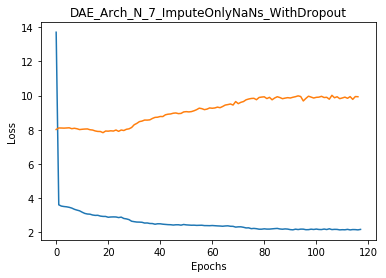

In [22]:
utils.plot_train_and_val_loss_curves(filename1= f"{model_name}/artifacts/loss_curve",
                                     filename2= f"{model_name}/artifacts/val_loss_curve",
                                     title=f"{model_name}")

In [23]:
# '''Remove folder before training again'''
# import shutil
# shutil.rmtree(model_name)

Learning Rate annealing:- Maybe need a smaller learning rate after a while? 
Nesterov momentum:- Check paper to see if all the features have been implemented exactly (like Nesterov?)
              
Experiments to try:
1. Plot different values for different architectures.
2. Try feeding in with just the imputed values instead of the whole predicted data.
3. Try without dropout.

Features needed:

1. Printing out the denormalized data in prediction - DONE
2. Store the ids of NaNs before filling them up with placeholders - Not Needed, wrote a better TEST FUNCTION
3. Do 70/30 Split before training, testing - DONE
4. Add provision in model for changing theta params - DONE
5. Add provision for removing dropout - DONE
6. Plotting Loss function - DONE

In [ ]:
# Saving model

#torch.save(optimizer.state_dict(), filename)
#optimizer.load_state_dict(torch.load(filename))

# Modelling Loading from saved point

# model =  Modelling.DenoisingAutoEncoder(len(trainset.variables()))
# model.load_state_dict(torch.load("./artifacts/saved_model_epoch50"))
# model.eval()

In [ ]:
#Tweaking the learning rate to improve convergence speed
# optimizer = Adam(net.parameters(), LR)

# 4. Testing

In [24]:
net = net.eval()
print((net(trainset[0][0]).detach()))
print(trainset[0][0])

tensor([0.2903, 0.5080, 0.3046, 0.5040, 0.2297, 0.5192, 0.2824, 0.7540, 0.7711])
tensor([0.2917, 0.5068, 0.6016, 0.5070, 0.3569, 0.5407, 0.5416, 0.6481, 0.5944])


In [25]:
net = net.eval()
print(trainset.get_denormalized_data((net(trainset[0][0].detach()))))
print(trainset.get_denormalized_data(trainset[0][0]))

           0          1          2          3          4           5  \
0  54.864635  11.608887  59.989624 -23.036865 -44.636734 -553.265625   

          6           7          8  
0 -1.211403  116.757812  123.64212  
      0    1     2    3        4    5          6          7          8
0  55.0  0.0  98.0  0.0  34.6819 -4.0  37.159561  50.757996  13.739258


In [26]:
import pandas as pd
import torch
def test_model(net=None, test_df= None, trainset=None, device =None, logger_level=20):
    """
    Function to evaluate the model on test set
    Should meet the following requirements:
        :-trainset - should be an object of class DataSetForImputation
        :-test_df - should be a Pandas dataframe with NaNs (if there are no NaNs, the same will be returned)
        :-net - should be an object of DenoisingAutoEncoder
    """
    assert isinstance(net, Modelling.DenoisingAutoEncoder)
    assert isinstance(test_df, pd.DataFrame)
    assert isinstance(trainset, dataset_module_categorical.DataSetForImputation)
    
    import logging
    logger = logging.getLogger()
    logger.setLevel(logger_level)
    
    NaN_test_df = test_df.reset_index(drop=True)  #Dropping index so that everything is reindexed from 0
       
    test_df = test_df.apply(lambda x: x.fillna(x.mean()), axis=0)
    test_df_norm = (test_df- trainset.min_df)/(trainset.max_df-trainset.min_df)
    test_df_tensor = torch.tensor(test_df_norm.values).to(device)
        
    net = net.eval()
    logging.debug(f"{test_df_tensor.shape}")
    pred = net(test_df_tensor)
     
    pred =  trainset.get_denormalized_data(pred)  #Predicted dataframe from the mode    
    
    # Replace the NaNs in the original test_df with newly imputed values
    final_pred = NaN_test_df.where(~NaN_test_df.isna(), other = pred)
    logging.debug(f"final_pred:\n {final_pred.head()}")
    
    return final_pred

In [27]:
test_model(net=net, test_df=test_df, trainset=trainset, device=device,logger_level=20).head()

,0,1,2,3,4,5,6,7,8
0,45,-1,76,0,-51.137756,-16,1.244999,121.835931,126.090099
1,37,0,95,0,10.000000,7,58.000000,84.000000,26.000000
2,37,0,75,-4,30.000000,0,38.000000,44.000000,6.000000
3,55,0,96,0,50.000000,4,41.000000,47.000000,6.000000
4,41,-1,76,0,-51.145715,-14,2.188854,122.843554,124.536250


In [28]:
full_test_df.head()

,0,1,2,3,4,5,6,7,8
15528,45,-1,76,0,44,-16,31,32,2
14327,37,0,95,0,10,7,58,84,26
12125,37,0,75,-4,30,0,38,44,6
39952,55,0,96,0,50,4,41,47,6
1339,41,-1,76,0,38,-14,35,37,2


# 5. Plotting Loss Curve

In [29]:
utils.plot_loss_curve(filename= f"{model_name}/artifacts/loss_curve", title=f"{model_name}")

FileNotFoundError: [Errno 2] No such file or directory: 'DAE_Arch_N_7_ImputeOnlyNaNs_WithDropout/artifacts/loss_curve'

### Model 2 DAE_Arch_N_7_ImputeOnlyNaNs_With10PercentDropout

In [30]:
import torch.utils.data as td
from torch.optim import Adam

LR = 1e-3
DATAPOINTS = len(trainset) 
BATCH_SIZE = 512 
BATCHES = DATAPOINTS/BATCH_SIZE
VARIABLES  = len(trainset.variables()) #9


import Modelling
net = Modelling.DenoisingAutoEncoder(len(trainset.variables()), theta = 7, input_dropout=0.1)

criterion = nn.MSELoss()
net = net.to(device) 

trainset = dataset_module_categorical.DataSetForImputation(train_df, normalize=True)
testset = dataset_module_categorical.DataSetForImputation(test_df, normalize=True)

train_loader = td.DataLoader(trainset, batch_size= BATCH_SIZE, shuffle= True, **kwargs)
val_loader  = td.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=True, **kwargs)

optimizer = Adam(net.parameters(), lr = LR)

LOG_INTERVAL = 10
SAVE_INTERVAL = 50
torch.set_printoptions(sci_mode=False)

In [31]:
model_name = "DAE_Arch_N_7_ImputeOnlyNaNs_With10PercentDropout"

In [32]:
train_model(0,101, net, model_name, train_loader=train_loader, val_loader=val_loader)

Epoch number:9 Loss: 2.4016


Epoch number:19 Loss: 2.0636


Epoch number:29 Loss: 1.7233


Epoch number:39 Loss: 1.5670


Epoch number:49 Loss: 1.4431


Epoch number:59 Loss: 1.2770


Epoch number:69 Loss: 1.1564


Epoch number:79 Loss: 1.0992


Epoch number:89 Loss: 1.0604


Epoch number:99 Loss: 1.0423


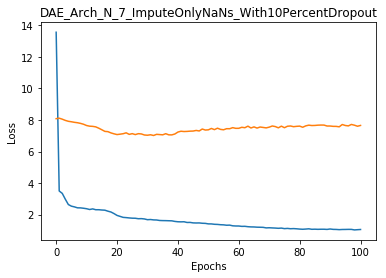

In [33]:
utils.plot_train_and_val_loss_curves(filename1= f"{model_name}/artifacts/loss_curve",
                                     filename2= f"{model_name}/artifacts/val_loss_curve",
                                     title=f"{model_name}")

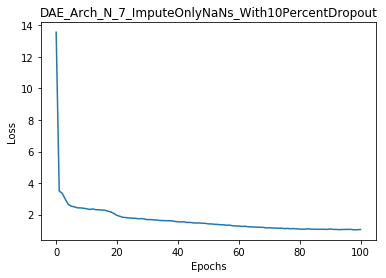

In [36]:
utils.plot_loss_curve(filename= f"{model_name}/artifacts/loss_curve", title=f"{model_name}")

In [34]:
test_model(net=net, test_df=test_df, trainset=trainset, device=device,logger_level=20).head()

,0,1,2,3,4,5,6,7,8
0,45,-1,76,0,27.903043,-16,26.327787,47.200214,18.001705
1,37,0,95,0,10.000000,7,58.000000,84.000000,26.000000
2,37,0,75,-4,30.000000,0,38.000000,44.000000,6.000000
3,55,0,96,0,50.000000,4,41.000000,47.000000,6.000000
4,41,-1,76,0,23.052367,-14,26.827119,50.897728,20.278981


In [35]:
full_test_df.head()

,0,1,2,3,4,5,6,7,8
15528,45,-1,76,0,44,-16,31,32,2
14327,37,0,95,0,10,7,58,84,26
12125,37,0,75,-4,30,0,38,44,6
39952,55,0,96,0,50,4,41,47,6
1339,41,-1,76,0,38,-14,35,37,2


### Model 3 DAE_Arch_N_7_ImputeOnlyNaNs_WithNoDropout

In [37]:
import torch.utils.data as td
from torch.optim import Adam

LR = 1e-3
DATAPOINTS = len(trainset) 
BATCH_SIZE = 512 
BATCHES = DATAPOINTS/BATCH_SIZE
VARIABLES  = len(trainset.variables()) #9


import Modelling
net = Modelling.DenoisingAutoEncoder(len(trainset.variables()), theta = 7, input_dropout=0.0)

criterion = nn.MSELoss()
net = net.to(device) 

trainset = dataset_module_categorical.DataSetForImputation(train_df, normalize=True)
testset = dataset_module_categorical.DataSetForImputation(test_df, normalize=True)

train_loader = td.DataLoader(trainset, batch_size= BATCH_SIZE, shuffle= True, **kwargs)
val_loader  = td.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=True, **kwargs)

optimizer = Adam(net.parameters(), lr = LR)

LOG_INTERVAL = 10
SAVE_INTERVAL = 50
torch.set_printoptions(sci_mode=False)

In [38]:
model_name = "DAE_Arch_N_7_ImputeOnlyNaNs_WithNoDropout"

In [39]:
train_model(0,101, net, model_name)

Epoch number:9 Loss: 1.1302


Epoch number:19 Loss: 0.5924


Epoch number:29 Loss: 0.3933


Epoch number:39 Loss: 0.3012


Epoch number:49 Loss: 0.3034


Epoch number:59 Loss: 0.2995


Epoch number:69 Loss: 0.2758


Epoch number:79 Loss: 0.2520


Epoch number:89 Loss: 0.3014


Epoch number:99 Loss: 0.3064


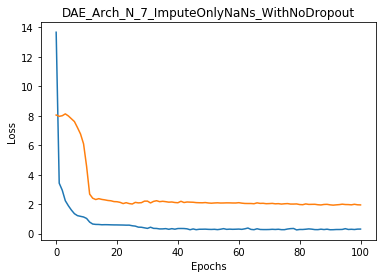

In [40]:
utils.plot_train_and_val_loss_curves(filename1= f"{model_name}/artifacts/loss_curve",
                                     filename2= f"{model_name}/artifacts/val_loss_curve",
                                     title=f"{model_name}")

In [41]:
test_model(net=net, test_df=test_df, trainset=trainset, device=device,logger_level=20).head()

,0,1,2,3,4,5,6,7,8
0,45,-1,76,0,30.672995,-16,36.073361,48.851995,12.892488
1,37,0,95,0,10.000000,7,58.000000,84.000000,26.000000
2,37,0,75,-4,30.000000,0,38.000000,44.000000,6.000000
3,55,0,96,0,50.000000,4,41.000000,47.000000,6.000000
4,41,-1,76,0,29.976551,-14,35.927004,48.163091,12.420868


In [42]:
full_test_df.head() 

,0,1,2,3,4,5,6,7,8
15528,45,-1,76,0,44,-16,31,32,2
14327,37,0,95,0,10,7,58,84,26
12125,37,0,75,-4,30,0,38,44,6
39952,55,0,96,0,50,4,41,47,6
1339,41,-1,76,0,38,-14,35,37,2


In [43]:
test_df.head()

,0,1,2,3,4,5,6,7,8
15528,45,-1,76,0,NaN,-16,NaN,NaN,NaN
14327,37,0,95,0,10.0,7,58.0,84.0,26.0
12125,37,0,75,-4,30.0,0,38.0,44.0,6.0
39952,55,0,96,0,50.0,4,41.0,47.0,6.0
1339,41,-1,76,0,NaN,-14,NaN,NaN,NaN


### Model 4 DAE_Arch_N_3_ImputeOnlyNaNs_WithDropout

In [44]:
import torch.utils.data as td
from torch.optim import Adam

LR = 1e-3
DATAPOINTS = len(trainset) 
BATCH_SIZE = 512 
BATCHES = DATAPOINTS/BATCH_SIZE
VARIABLES  = len(trainset.variables()) #9


import Modelling
net = Modelling.DenoisingAutoEncoder(len(trainset.variables()), theta = 3, input_dropout=0.5)

criterion = nn.MSELoss()
net = net.to(device) 

trainset = dataset_module_categorical.DataSetForImputation(train_df, normalize=True)
testset = dataset_module_categorical.DataSetForImputation(test_df, normalize=True)

train_loader = td.DataLoader(trainset, batch_size= BATCH_SIZE, shuffle= True, **kwargs)
val_loader  = td.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=True, **kwargs)

optimizer = Adam(net.parameters(), lr = LR)

LOG_INTERVAL = 10
SAVE_INTERVAL = 50
torch.set_printoptions(sci_mode=False)

In [45]:
model_name = "DAE_Arch_N_3_ImputeOnlyNaNs_WithDropout"

In [46]:
train_model(0,101, net, model_name)

Epoch number:9 Loss: 3.4212


Epoch number:19 Loss: 3.0145


Epoch number:29 Loss: 2.8893


Epoch number:39 Loss: 2.8689


Epoch number:49 Loss: 2.7856


Epoch number:59 Loss: 2.5245


Epoch number:69 Loss: 2.4665


Epoch number:79 Loss: 2.4359


Epoch number:89 Loss: 2.3959


Epoch number:99 Loss: 2.4180


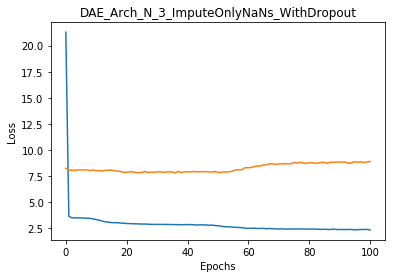

In [47]:
utils.plot_train_and_val_loss_curves(filename1= f"{model_name}/artifacts/loss_curve",
                                     filename2= f"{model_name}/artifacts/val_loss_curve",
                                     title=f"{model_name}")

In [48]:
test_model(net=net, test_df=test_df, trainset=trainset, device=device,logger_level=20).head()

,0,1,2,3,4,5,6,7,8
0,45,-1,76,0,12.086481,-16,7.961649,22.045813,23.953802
1,37,0,95,0,10.000000,7,58.000000,84.000000,26.000000
2,37,0,75,-4,30.000000,0,38.000000,44.000000,6.000000
3,55,0,96,0,50.000000,4,41.000000,47.000000,6.000000
4,41,-1,76,0,10.672318,-14,8.899876,25.765867,27.338888


In [49]:
full_test_df.head() 

,0,1,2,3,4,5,6,7,8
15528,45,-1,76,0,44,-16,31,32,2
14327,37,0,95,0,10,7,58,84,26
12125,37,0,75,-4,30,0,38,44,6
39952,55,0,96,0,50,4,41,47,6
1339,41,-1,76,0,38,-14,35,37,2


In [50]:
test_df.head()

,0,1,2,3,4,5,6,7,8
15528,45,-1,76,0,NaN,-16,NaN,NaN,NaN
14327,37,0,95,0,10.0,7,58.0,84.0,26.0
12125,37,0,75,-4,30.0,0,38.0,44.0,6.0
39952,55,0,96,0,50.0,4,41.0,47.0,6.0
1339,41,-1,76,0,NaN,-14,NaN,NaN,NaN


### Model 5 DAE_Arch_N_3_ImputeOnlyNaNs_With10PercentDropout

In [51]:
import torch.utils.data as td
from torch.optim import Adam

LR = 1e-3
DATAPOINTS = len(trainset) 
BATCH_SIZE = 512 
BATCHES = DATAPOINTS/BATCH_SIZE
VARIABLES  = len(trainset.variables()) #9


import Modelling
net = Modelling.DenoisingAutoEncoder(len(trainset.variables()), theta = 3, input_dropout=0.1)

criterion = nn.MSELoss()
net = net.to(device) 

trainset = dataset_module_categorical.DataSetForImputation(train_df, normalize=True)
testset = dataset_module_categorical.DataSetForImputation(test_df, normalize=True)

train_loader = td.DataLoader(trainset, batch_size= BATCH_SIZE, shuffle= True, **kwargs)
val_loader  = td.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=True, **kwargs)

optimizer = Adam(net.parameters(), lr = LR)

LOG_INTERVAL = 10
SAVE_INTERVAL = 50
torch.set_printoptions(sci_mode=False)

In [52]:
model_name = "DAE_Arch_N_3_ImputeOnlyNaNs_With10PercentDropout"

In [53]:
train_model(0,101, net, model_name)

Epoch number:9 Loss: 2.4650


Epoch number:19 Loss: 2.3130


Epoch number:29 Loss: 2.2213


Epoch number:39 Loss: 1.8527


Epoch number:49 Loss: 1.6958


Epoch number:59 Loss: 1.6121


Epoch number:69 Loss: 1.5186


Epoch number:79 Loss: 1.4467


Epoch number:89 Loss: 1.3902


Epoch number:99 Loss: 1.3358


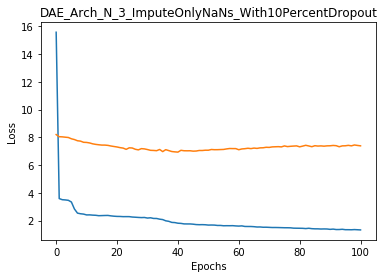

In [54]:
utils.plot_train_and_val_loss_curves(filename1= f"{model_name}/artifacts/loss_curve",
                                     filename2= f"{model_name}/artifacts/val_loss_curve",
                                     title=f"{model_name}")

In [55]:
test_model(net=net, test_df=test_df, trainset=trainset, device=device,logger_level=20).head()

,0,1,2,3,4,5,6,7,8
0,45,-1,76,0,29.667679,-16,27.987846,44.119046,16.490343
1,37,0,95,0,10.000000,7,58.000000,84.000000,26.000000
2,37,0,75,-4,30.000000,0,38.000000,44.000000,6.000000
3,55,0,96,0,50.000000,4,41.000000,47.000000,6.000000
4,41,-1,76,0,29.430014,-14,28.234115,43.229323,15.179403


In [56]:
full_test_df.head() 

,0,1,2,3,4,5,6,7,8
15528,45,-1,76,0,44,-16,31,32,2
14327,37,0,95,0,10,7,58,84,26
12125,37,0,75,-4,30,0,38,44,6
39952,55,0,96,0,50,4,41,47,6
1339,41,-1,76,0,38,-14,35,37,2


In [57]:
test_df.head()

,0,1,2,3,4,5,6,7,8
15528,45,-1,76,0,NaN,-16,NaN,NaN,NaN
14327,37,0,95,0,10.0,7,58.0,84.0,26.0
12125,37,0,75,-4,30.0,0,38.0,44.0,6.0
39952,55,0,96,0,50.0,4,41.0,47.0,6.0
1339,41,-1,76,0,NaN,-14,NaN,NaN,NaN


### Model 7 DAE_Arch_N_9_ImputeOnlyNaNs_WithNoDropout

In [58]:
import torch.utils.data as td
from torch.optim import Adam

LR = 1e-3
DATAPOINTS = len(trainset) 
BATCH_SIZE = 512 
BATCHES = DATAPOINTS/BATCH_SIZE
VARIABLES  = len(trainset.variables()) #9


import Modelling
net = Modelling.DenoisingAutoEncoder(len(trainset.variables()), theta = 9, input_dropout=0.0)

criterion = nn.MSELoss()
net = net.to(device) 

trainset = dataset_module_categorical.DataSetForImputation(train_df, normalize=True)
testset = dataset_module_categorical.DataSetForImputation(test_df, normalize=True)

train_loader = td.DataLoader(trainset, batch_size= BATCH_SIZE, shuffle= True, **kwargs)
val_loader  = td.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=True, **kwargs)

optimizer = Adam(net.parameters(), lr = LR)

LOG_INTERVAL = 10
SAVE_INTERVAL = 50
torch.set_printoptions(sci_mode=False)

In [1]:
model_name = "DAE_Arch_N_9_ImputeOnlyNaNs_WithNoDropout"

In [60]:
train_model(0,101, net, model_name)

Epoch number:9 Loss: 0.8463


Epoch number:19 Loss: 0.5126


Epoch number:29 Loss: 0.3341


Epoch number:39 Loss: 0.2927


Epoch number:49 Loss: 0.2881


Epoch number:59 Loss: 0.3089


Epoch number:69 Loss: 0.2707


Epoch number:79 Loss: 0.3513


Epoch number:89 Loss: 0.2997


Epoch number:99 Loss: 0.2728


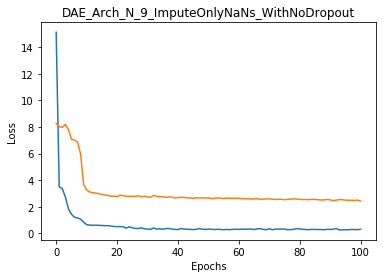

In [5]:
utils.plot_train_and_val_loss_curves(filename1= f"{model_name}/artifacts/loss_curve",
                                     filename2= f"{model_name}/artifacts/val_loss_curve",
                                     title=f"{model_name}")

In [ ]:
test_model(net=net, test_df=test_df, trainset=trainset, device=device,logger_level=20).head()

In [ ]:
full_test_df.head() 

In [ ]:
test_df.head()